# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [4]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

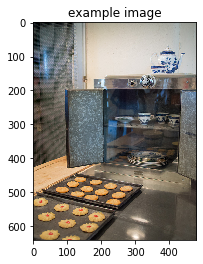

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [9]:
# Watch for any changes in model.py, and re-load it automatically.
#% load_ext autoreload
#% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl' 
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 256

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(8856, 256)
  (lstm): LSTM(256, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=8856, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [13]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: tensor([[[-0.7635, -0.4392, -0.3222,  0.0207,  0.0639, -0.0119,  0.0969,
           1.0426,  0.0132,  0.1073,  0.0883,  0.1452,  0.1320,  0.1467,
          -0.1650, -0.0528, -0.4114, -1.0557, -0.6199,  0.2714, -0.4879,
          -0.7887, -0.3523, -0.1958, -0.1278,  0.4163, -0.8332,  0.1951,
          -0.6023,  0.0631, -0.1671, -0.2778, -0.0388, -0.0852,  0.3166,
           0.2949, -0.1706,  0.4996,  0.1765,  0.1201,  0.2483,  0.8805,
          -0.7219,  0.4697,  0.1616,  0.5597,  0.0154, -0.1885,  0.1082,
           0.7607, -0.0977, -0.1438,  0.8313,  0.0413,  0.4648, -0.9257,
           0.3557,  0.5299, -0.4617, -0.5087, -0.2979,  0.1389, -0.0153,
          -0.0739, -0.2295,  0.1279,  0.3547, -0.4270, -0.2357,  0.5057,
           0.0650, -0.1294,  0.3118, -0.4167, -0.0438,  0.0016, -0.1136,
          -0.1265, -0.2643, -0.0411,  0.1807, -0.2517,  0.2547,  0.2449,
          -0.6126, -0.5298,  0.0579,  0.2819,  0.3712,  0.6423, -0.0611,
          -0.4225,  0.3297,  0.2401

AssertionError: Output needs to be a Python list

<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [19]:
# TODO #4: Complete the function.
def clean_sentence(output):   
    return sentence

In [18]:
print(output)

tensor([[[-0.7635, -0.4392, -0.3222,  0.0207,  0.0639, -0.0119,  0.0969,
           1.0426,  0.0132,  0.1073,  0.0883,  0.1452,  0.1320,  0.1467,
          -0.1650, -0.0528, -0.4114, -1.0557, -0.6199,  0.2714, -0.4879,
          -0.7887, -0.3523, -0.1958, -0.1278,  0.4163, -0.8332,  0.1951,
          -0.6023,  0.0631, -0.1671, -0.2778, -0.0388, -0.0852,  0.3166,
           0.2949, -0.1706,  0.4996,  0.1765,  0.1201,  0.2483,  0.8805,
          -0.7219,  0.4697,  0.1616,  0.5597,  0.0154, -0.1885,  0.1082,
           0.7607, -0.0977, -0.1438,  0.8313,  0.0413,  0.4648, -0.9257,
           0.3557,  0.5299, -0.4617, -0.5087, -0.2979,  0.1389, -0.0153,
          -0.0739, -0.2295,  0.1279,  0.3547, -0.4270, -0.2357,  0.5057,
           0.0650, -0.1294,  0.3118, -0.4167, -0.0438,  0.0016, -0.1136,
          -0.1265, -0.2643, -0.0411,  0.1807, -0.2517,  0.2547,  0.2449,
          -0.6126, -0.5298,  0.0579,  0.2819,  0.3712,  0.6423, -0.0611,
          -0.4225,  0.3297,  0.2401,  0.5667, -0.02

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [20]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

KeyError: tensor([[-0.7635, -0.4392, -0.3222,  0.0207,  0.0639, -0.0119,  0.0969,  1.0426,
          0.0132,  0.1073,  0.0883,  0.1452,  0.1320,  0.1467, -0.1650, -0.0528,
         -0.4114, -1.0557, -0.6199,  0.2714, -0.4879, -0.7887, -0.3523, -0.1958,
         -0.1278,  0.4163, -0.8332,  0.1951, -0.6023,  0.0631, -0.1671, -0.2778,
         -0.0388, -0.0852,  0.3166,  0.2949, -0.1706,  0.4996,  0.1765,  0.1201,
          0.2483,  0.8805, -0.7219,  0.4697,  0.1616,  0.5597,  0.0154, -0.1885,
          0.1082,  0.7607, -0.0977, -0.1438,  0.8313,  0.0413,  0.4648, -0.9257,
          0.3557,  0.5299, -0.4617, -0.5087, -0.2979,  0.1389, -0.0153, -0.0739,
         -0.2295,  0.1279,  0.3547, -0.4270, -0.2357,  0.5057,  0.0650, -0.1294,
          0.3118, -0.4167, -0.0438,  0.0016, -0.1136, -0.1265, -0.2643, -0.0411,
          0.1807, -0.2517,  0.2547,  0.2449, -0.6126, -0.5298,  0.0579,  0.2819,
          0.3712,  0.6423, -0.0611, -0.4225,  0.3297,  0.2401,  0.5667, -0.0266,
          1.1381,  0.2471, -0.1944,  0.6034, -0.0997, -1.2070,  0.4788,  0.0263,
         -0.8021,  0.1501,  0.0264,  0.4259,  0.2263, -0.4797,  0.0515,  0.3156,
         -0.1510, -0.0135,  0.2598,  0.0373, -0.9124, -0.6499, -0.0985, -0.6513,
          0.1608,  0.3712, -0.5508, -0.5635, -0.3204,  0.3230,  0.5404, -0.4265,
         -0.2300, -0.3059,  0.1637,  1.1472,  0.0509, -0.1935,  0.1046, -0.3869,
          0.1184,  0.7330,  0.2239,  0.0204,  0.7144,  0.0362,  0.1552,  0.3198,
         -0.0526,  0.1618,  0.1919, -0.1262, -0.3366,  0.9131,  0.2567, -0.0678,
         -0.1766,  0.4234, -0.1653, -0.1201, -0.2697, -0.3039,  0.4410,  0.4271,
         -0.3566, -0.7887,  0.2450,  0.0092, -0.2024, -0.0604, -0.0608, -0.3043,
          0.4390, -0.4054, -0.0430, -0.0530,  0.1332,  0.4344,  0.2659, -0.1395,
          0.7605,  0.2271,  0.1889, -0.0512, -0.0660,  0.2250, -0.1626,  0.0931,
         -0.4894,  0.1545,  0.4455, -0.0473, -0.0670, -0.1892,  0.1548,  0.0738,
         -0.1042,  0.0379,  0.3614,  0.0103, -0.2234,  0.4824,  0.0066,  0.2213,
         -0.2240,  0.5493, -0.2788,  0.0517, -0.0374,  0.8103,  0.0057, -0.0569,
         -0.2336,  0.4225,  0.0492,  0.0119, -0.4936, -0.4252, -0.1688, -0.3167,
         -0.0854, -0.0868, -0.0785, -0.2562, -0.2198, -0.3973, -0.2170,  0.0742,
         -0.2810, -0.0147, -0.3830,  0.4034, -0.1101, -0.5284,  0.5228,  0.3680,
         -0.2340,  0.4016, -0.7537,  0.1510, -0.3184,  0.2649,  0.4079,  0.6641,
          0.1041,  0.0386, -0.1344, -0.4816,  0.1896, -0.1038, -0.4485,  0.6329,
          0.1380, -0.9534,  0.1756,  0.1346,  0.2929, -0.0229,  0.1062,  0.2826]],
       device='cuda:0', grad_fn=<SelectBackward>)

<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [ ]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

In [ ]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

In [ ]:
get_prediction()

In [ ]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

In [ ]:
get_prediction()

In [ ]:
get_prediction()